In [695]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.ensemble import RandomForestClassifier
# For data preprocess
import numpy as np
import csv
import os
import pandas as pd
# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler
myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)
import plotly.graph_objects as go

In [674]:
import torch.nn.functional as  F

In [675]:
train_data=pd.read_csv("C:\\wangao\\HW1\\covid.train.csv")
test_data=pd.read_csv("C:\\wangao\\HW1\\covid.test.csv")

In [676]:
train_data=train_data.iloc[:,1:]

In [677]:
train_data.columns#获取了多种所选的特征，前面是所在地区的one hot

Index(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'FL', 'GA', 'ID', 'IL', 'IN',
       'IA', 'KS', 'KY', 'LA', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'NE', 'NV',
       'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TX', 'UT',
       'VA', 'WA', 'WV', 'WI', 'cli', 'ili', 'hh_cmnty_cli', 'nohh_cmnty_cli',
       'wearing_mask', 'travel_outside_state', 'work_outside_home', 'shop',
       'restaurant', 'spent_time', 'large_event', 'public_transit', 'anxious',
       'depressed', 'felt_isolated', 'worried_become_ill', 'worried_finances',
       'tested_positive', 'cli.1', 'ili.1', 'hh_cmnty_cli.1',
       'nohh_cmnty_cli.1', 'wearing_mask.1', 'travel_outside_state.1',
       'work_outside_home.1', 'shop.1', 'restaurant.1', 'spent_time.1',
       'large_event.1', 'public_transit.1', 'anxious.1', 'depressed.1',
       'felt_isolated.1', 'worried_become_ill.1', 'worried_finances.1',
       'tested_positive.1', 'cli.2', 'ili.2', 'hh_cmnty_cli.2',
       'nohh_cmnty_cli.2', 'wearing_m

数据的具体描述是这样，分别给了四十个state的独热编码，$18\times 3$其中每一天都会测算对应的核酸检测，基于机器学习和神经网络的检测，来实现

In [678]:
array_data=np.array(train_data).astype('float')

In [679]:
#撰写对应的Dataset的所在类

In [680]:
def feature_selection(data_Frame):
    std=StandardScaler()
    rnd_dataFrame=data_Frame.iloc[:,40:]
    ar_data=np.array(rnd_dataFrame)
    feature_columns=list(rnd_dataFrame.columns)
    x_train=ar_data[:,:-1].astype('float')
    y_train=ar_data[:,-1]
    rnd_clf=RandomForestClassifier(n_estimators=1000,max_leaf_nodes=20,n_jobs=-1)
    rnd_clf.fit(x_train,y_train.astype('int'))
    rnf_feature=pd.DataFrame(rnd_clf.feature_importances_)
    rnf_feature.index=feature_columns[:-1]
    rnf_feature['indice']=list(range(40,93))
    rnf_feature.sort_values(by=0,ascending=False,inplace=True)
    #
    return sorted(list(np.array(rnf_feature.iloc[:,:5]['indice'])))

In [681]:
a=sorted(feature_selection(train_data))

In [682]:
a==list(range(40,93))

True

In [683]:
array_data[:,-1].shape

(2700,)

In [684]:
class COVID19(Dataset):
    def __init__(self,path='C:\\wangao\\HW1',mode='train',target_only=False):
        self.mode=mode
        self.path=path
        if(mode=='dev'):
            self.mode_filename='covid.'+'train'+'.csv'
        else:
            self.mode_filename='covid.'+mode+'.csv'
        ###pandas读取对应的数据
        df_data=pd.read_csv(os.path.join(self.path,self.mode_filename))
        #去掉前面的array_data
        df_data=df_data.iloc[:,1:]
        self.df_data=df_data
        #获取对应的DataFrame格式的数据
        ar_data=np.array(df_data)
        self.ar_data=ar_data
        if not target_only:
            feats=list(range(93))
            #feats=list(range(40))
            #feature=feature_selection(df_data)
            #feats=feats+feature
        else:
            feats=list(range(40))
            feats.append(57)
            feats.append(75)
        if mode=='test':
            data=ar_data[:,feats]
            self.data=torch.FloatTensor(ar_data)
        else:
            data=ar_data[:,feats]
            target=ar_data[:,-1]
            if mode=='train':#分隔开对应validation_dataset
                indices=[i for i in range(len(data)) if(i%10!=0)]
            elif mode=='dev':
                indices=[i for i in range(len(data))if (i%10==0)]
            self.data=torch.FloatTensor(data[indices])
            self.target=torch.FloatTensor(target[indices])
        #对于非独热编码的正则化处理，在dim=0上
        self.data[:,40:]=(self.data[:,40:]-self.data[:,40:].mean(dim=0))/(self.data[:,40:].std(dim=0))
        #输出对应的特征的种类
        self.dim=self.data.shape[1]
    def __getitem__(self,idx):
        if(self.mode in ['train','dev']):
            return self.data[idx],self.target[idx]
        else:
            return self.data[idx]
    def __len__(self):
        return len(self.data)
    def feature_selection(data_Frame):
        std=StandardScaler()
        rnd_dataFrame=data_Frame.iloc[:,40:]
        ar_data=np.array(rnd_dataFrame)
        feature_columns=list(rnd_dataFrame.columns)
        x_train=ar_data[:,:-1].astype('float')
        y_train=ar_data[:,-1]
        rnd_clf=RandomForestClassifier(n_estimators=1000,max_leaf_nodes=20,n_jobs=-1)
        rnd_clf.fit(x_train,y_train.astype('int'))
        rnf_feature=pd.DataFrame(rnd_clf.feature_importances_)
        rnf_feature.index=feature_columns[:-1]
        rnf_feature['indice']=list(range(40,93))
        rnf_feature.sort_values(by=0,ascending=False,inplace=True)
    
        return sorted(list(np.array(rnf_feature.iloc[:,:10]['indice'])))
    
        

In [685]:
def pre_dataloader(batch_size,mode,num_workers,path,target_only):
    datasets=COVID19(path,mode,target_only)
    if(mode in ['train','dev']):
        shuffle=True
    else:
        shuffle=False
    cur_dataloader=DataLoader(dataset=datasets,batch_size=batch_size,shuffle=shuffle,num_workers=num_workers)
    return cur_dataloader

In [686]:
class Covid_Predict(nn.Module):
    def __init__(self,in_dims):
        super().__init__()
        self.fc1=nn.Linear(in_dims,128)
        self.fc2=nn.Linear(128,64)
        self.fc3=nn.Linear(64,16)
        self.fc4=nn.Linear(16,1)
        self.criterion=nn.MSELoss(reduction='mean')
    def forward(self,x):
        x=self.fc1(x)
        x=F.relu(x)
        x=self.fc2(x)
        x=F.relu(x)
        x=self.fc3(x)
        x=F.relu(x)
        x=self.fc4(x)
        return x.squeeze(1)
    def cal_loss(self,pred,target):
        return self.criterion(pred,target)
        

In [687]:
def train(tr_loader,dv_loader,model,device):
    n_epochs=3000
    optimizer=torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
    min_mse=100
    earlt_stop=1000
    loss_record={'train':[],'dev':[]}
    earlt_stop_cnt=0
    epoch=0
    while(epoch<n_epochs):
        model.train()
        for x,y in tr_loader:
            optimizer.zero_grad()
            x,y=x.to(device),y.to(device)
            pred=model(x)
            mse_loss=model.cal_loss(pred,y)
            mse_loss.backward()
            optimizer.step()
            loss_record['train'].append(mse_loss.detach().cpu().item())
        dev_mse=dev(dv_loader,model,device)
        if dev_mse<min_mse:
            min_mse=dev_mse
            print('Saving model epoch {:4d}loss{:.4f}'.format(epoch+1,min_mse))
            torch.save(model.state_dict(),'C:\\wangao\HW1\\model_param.pth')
            earlt_stop_cnt=0
        else:
            earlt_stop_cnt+=1
        epoch+=1
        loss_record['dev'].append(dev_mse)
        if earlt_stop_cnt>earlt_stop:
            break
    print("已经完成{0}".format(epoch))
    return min_mse,loss_record
            

In [688]:
def dev(dev_loader,model,device):
    model.eval()
    total_loss=0
    for x,y in dv_set:
        x,y=x.to(device),y.to(device)
        with torch.no_grad():
            pred=model(x)
            mse_loss=model.cal_loss(pred,y)
        total_loss+=mse_loss.detach().cpu().item()*len(x)
    total_loss=total_loss/(len(dev_loader.dataset))
    return total_loss                

In [689]:
device='cpu'
target_only=False

In [690]:
tr_set=pre_dataloader(batch_size=128,num_workers=0,mode='train',path='C:\\wangao\\HW1',target_only=False)
dv_set=pre_dataloader(batch_size=128,num_workers=0,mode='dev',path='C:\\wangao\\HW1',target_only=False)
tt_set=pre_dataloader(batch_size=270,num_workers=0,mode='test',path='C:\\wangao\\HW1',target_only=False)

In [691]:
model=Covid_Predict(tr_set.dataset.dim).to(device)

In [692]:
model_loss,model_loss_record=train(tr_set,dv_set,model,device)

Saving model epoch    1loss91.2981
Saving model epoch    2loss24.8221
Saving model epoch    3loss5.3189
Saving model epoch    4loss1.9930
Saving model epoch    5loss1.6431
Saving model epoch    6loss1.5205
Saving model epoch    7loss1.4095
Saving model epoch    9loss1.3305
Saving model epoch   10loss1.2707
Saving model epoch   11loss1.1946
Saving model epoch   12loss1.1779
Saving model epoch   14loss1.1505
Saving model epoch   15loss1.0487
Saving model epoch   17loss1.0168
Saving model epoch   18loss0.9936
Saving model epoch   23loss0.9402
Saving model epoch   25loss0.9196
Saving model epoch   26loss0.9101
Saving model epoch   30loss0.8846
Saving model epoch   32loss0.8752
Saving model epoch   35loss0.8521
Saving model epoch   41loss0.8481
Saving model epoch   42loss0.8431
Saving model epoch   46loss0.8108
Saving model epoch   49loss0.7978
Saving model epoch   63loss0.7690
Saving model epoch   68loss0.7591
Saving model epoch   76loss0.7458
Saving model epoch   96loss0.7400
Saving model

In [702]:
len(model_loss_record['train'])

19

In [749]:
def plot_learning_curve(loss_record,title=''):
    x1=list(range(len(loss_record['train'])))[0:5000]
    x2=x1[::(len(loss_record['train'])//len(loss_record['dev']))]
    fig=go.Figure()
    xlim = [0, 200]
    ylim = [0.0, 5]
    fig.add_trace(go.Scatter(x=x1,y=loss_record['train'],mode="lines",name="loss",marker=dict(symbol=18,size = 10)))
    fig.add_trace(go.Scatter(x=x2,y=loss_record['dev'],mode="lines",name="val_loss",marker=dict(symbol=2,size = 10)))
  # `fig.update_xaxes(range=[0.0, 5000])
    fig.update_yaxes(range=[0.0, 5])
    fig.update_layout(title="learning curve of{}".format(title),xaxis_title='Training steps',yaxis_title='MSE loss')
   # fig.add_annotation(x=len(x1),y=loss_record['train'][0:100][-1],text=str(np.round(loss_record['train'][0:100][-1]*100,4))+"%",
        #    opacity=0.7,arrowcolor="blue",textangle=0,ax=20,ay=20,
       #     arrowsize=2,
         #   arrowwidth=1,
          #  arrowhead=7,font=dict(size=20))
    #fig.add_annotation(x=len(x2),y=loss_record['dev'][0:100][-1],text=str(np.round(loss_record['dev'][0:100][-1]*100,4))+"%",xshift=2,
           # opacity=0.8,arrowcolor="Red",
            #arrowsize=2,
            #arrowwidth=1,
            #arrowhead=7,font=dict(size=20))
    fig.show()

In [750]:
plot_learning_curve(model_loss_record,title='deep_model')

In [751]:
def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

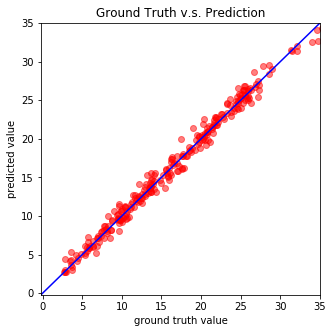

In [755]:
model = Covid_Predict(tr_set.dataset.dim).to(device)
ckpt = torch.load("C:\\wangao\HW1\\model_param.pth", map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set